# EigenCWD Demo Notebook
This is a minimal working example for the eigenCWD algorithm.

In [1]:
%load_ext autoreload
%autoreload 2
    
import matplotlib.pyplot as plt
from eigencwd.eigencwd import EigenCWD
from eigencwd.eigenpsf import EigenPSF
from eigencwd import optics
from eigencwd import utils
from PIL import Image
import numpy as np
import torch

## Create lens function
Here we demonstrate using a hyperbolic lens profile. Other available options include 'parabolic' and 'spherical'.

In [2]:
n_pixels = 601
focus = 173e-6
wavelength = 740e-9
diameter = 200e-6
dx = 4e-7
device = "cuda" #set to cuda if gpu is available

In [3]:
lens = optics.lens(
    N=n_pixels,
    lenswavelength=wavelength,
    diameter=diameter,
    f=focus,
    dx=dx,
    device=device,
)
lensfunction = lens.create_lens_function(lens_type='hyperbolic')

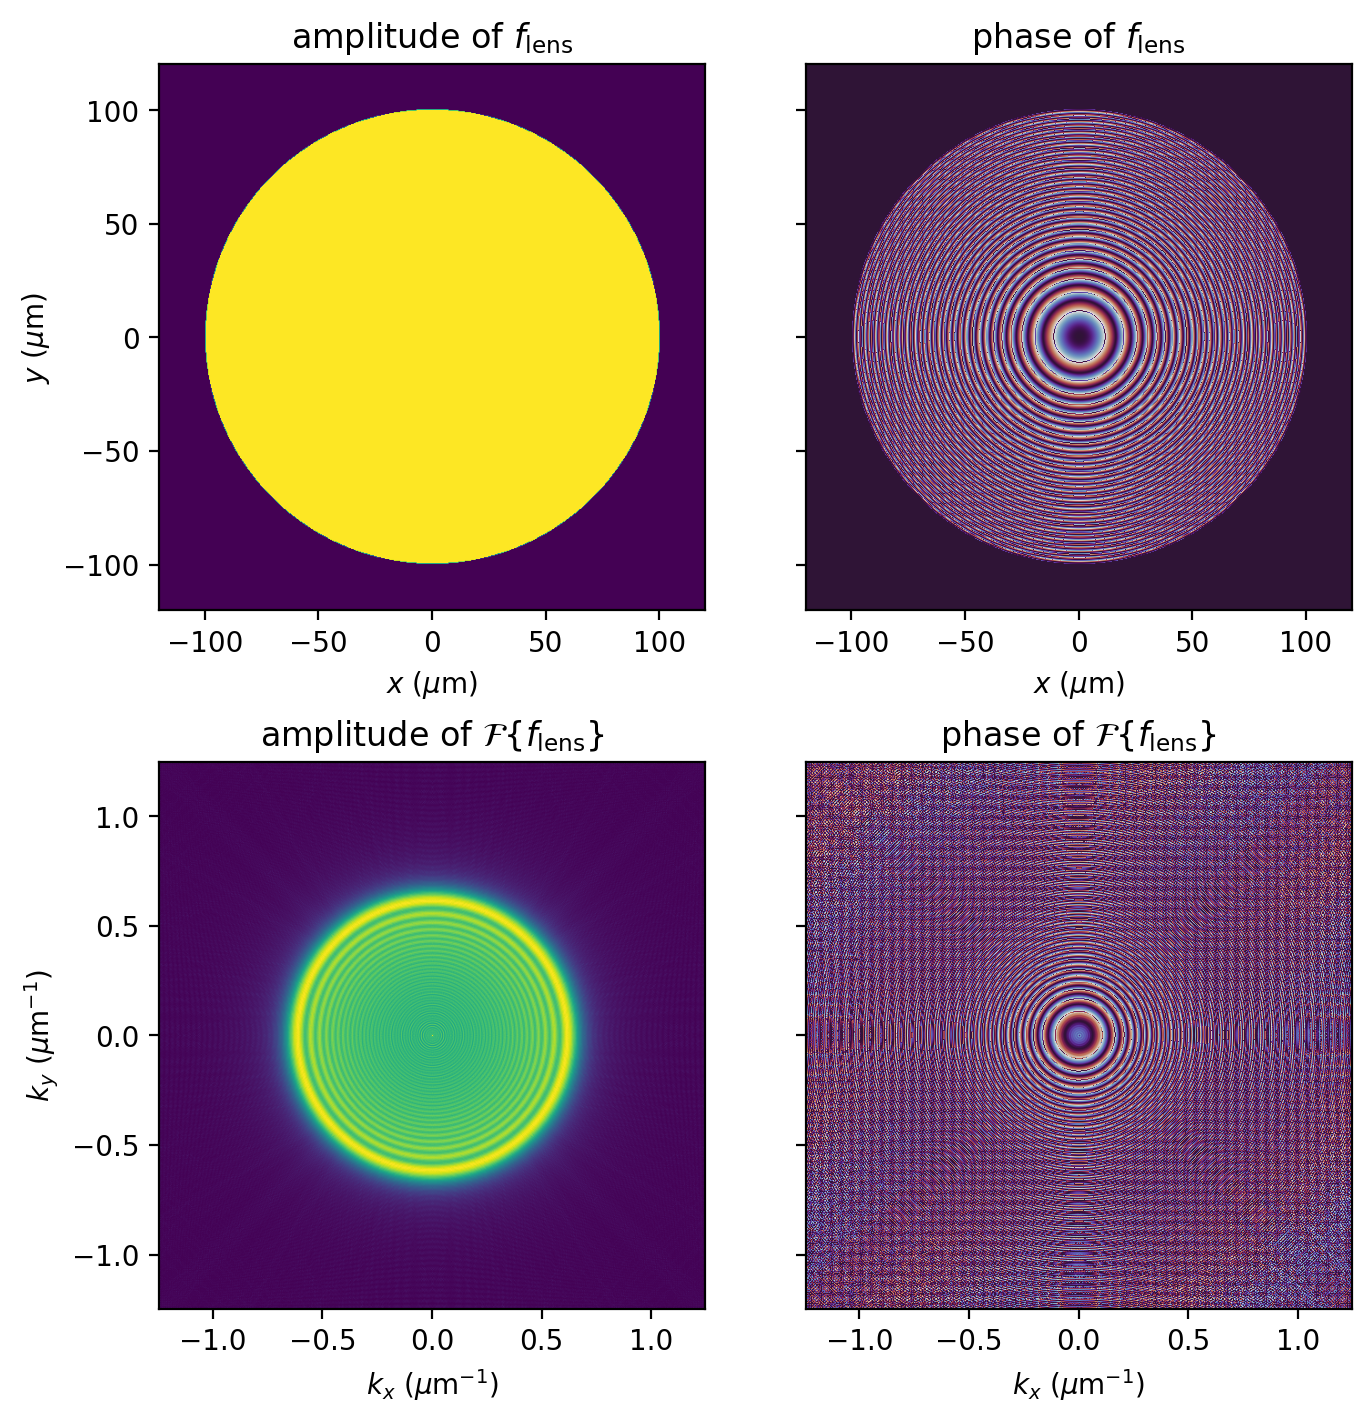

In [4]:
lens.view_lens_function(units_scale=1e-6)

## Import image
We include both cameraman and tiled USAF images used in the manuscript.

In [5]:
sz = 255

usaf = Image.open("../data/3x3usaf.png")
usaf = usaf.resize((sz, sz))
usaf = usaf.convert("L")
usaf = np.asarray(usaf)
usaf = (usaf - np.mean(usaf[0])) / (np.max(usaf) - np.mean(usaf[0]))
usaf[usaf < 0] = 0


camera = Image.open("../data/256cameraman.tif")
camera = camera.resize((sz, sz))
camera = camera.convert("L")
camera = np.asarray(camera)
camera = (camera - np.min(camera)) / (np.max(camera) - np.min(camera))
camera[camera < 0] = 0


psf_sz = 121
padded_camera = utils.pad2d(camera, sz + psf_sz - 1)
padded_usaf = utils.pad2d(usaf, sz + psf_sz - 1)
padded_usaf.shape

(375, 375)

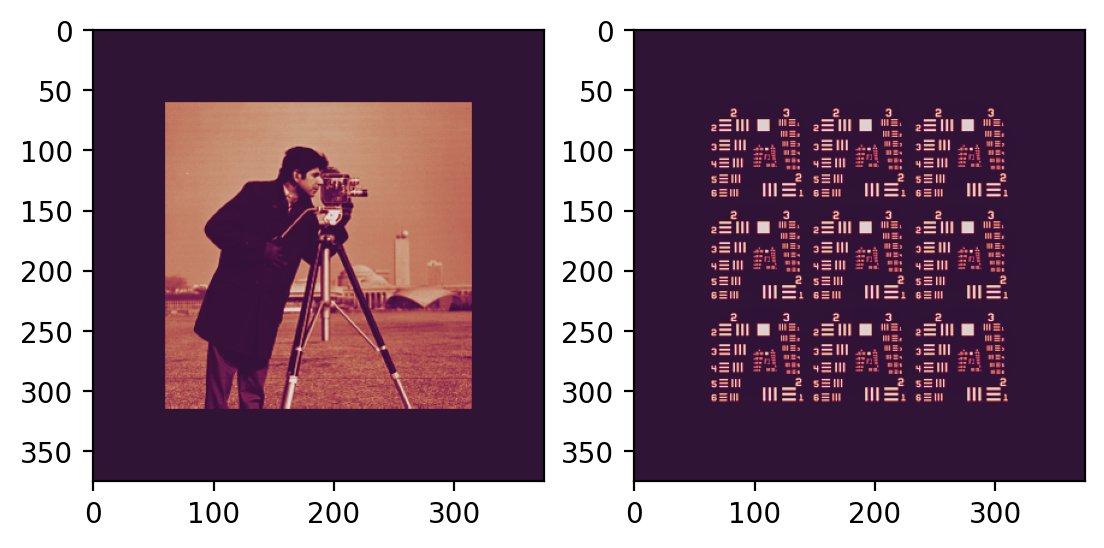

In [6]:
fig, axes = plt.subplots(1, 2, dpi=200)
ax = axes[0]
ax.imshow(padded_camera, cmap='twilight', vmin=-1, vmax=1)
ax = axes[1]
ax.imshow(padded_usaf, cmap='twilight', vmin=-1, vmax=1)
plt.show()

## Blur image
Here we use the tiled USAF image for demonstration. Change the inputs to 'padded_camera' in the appropriate code blocks to repeat the simulations with the cameraman image.

In [7]:
obj_dist_from_lens = 2 # [m]
psfmag = 1 # magnification factor for wave propagation.

M = focus / obj_dist_from_lens
olength = padded_usaf.shape[0] * dx / M / psfmag
lens.create_object(
    torch.from_numpy(padded_usaf).to(device),
    object_size=olength,
    object_distance=obj_dist_from_lens,
)

In [8]:
angular_fov = lens.half_angle_fov * 2
print(angular_fov)

tensor(46.8760)


In [9]:
# the values used in the manuscript ranges between [3,5,7,9,11,13,15,17,19]
# note that plotting the next 3 figures with large number of blocks will be slower.
n_blocks = 19 

psf_list, psf_coords = lens.create_varying_psfs(
    n_blocks=n_blocks,
    psf_size=psf_sz,
    psfmag=psfmag,
    extend_to_edge=True,
    prop_dist=focus,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.94it/s]


In [10]:
padded_obj_coord = [lens.objecty, lens.objectx]

eigp = EigenPSF(
    torch.from_numpy(padded_usaf),
    psf_list,
    psf_coords,
    padded_obj_coord,
    verbose=False,
)
eigp.blur_image(plots=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [01:01<00:00,  5.86it/s]


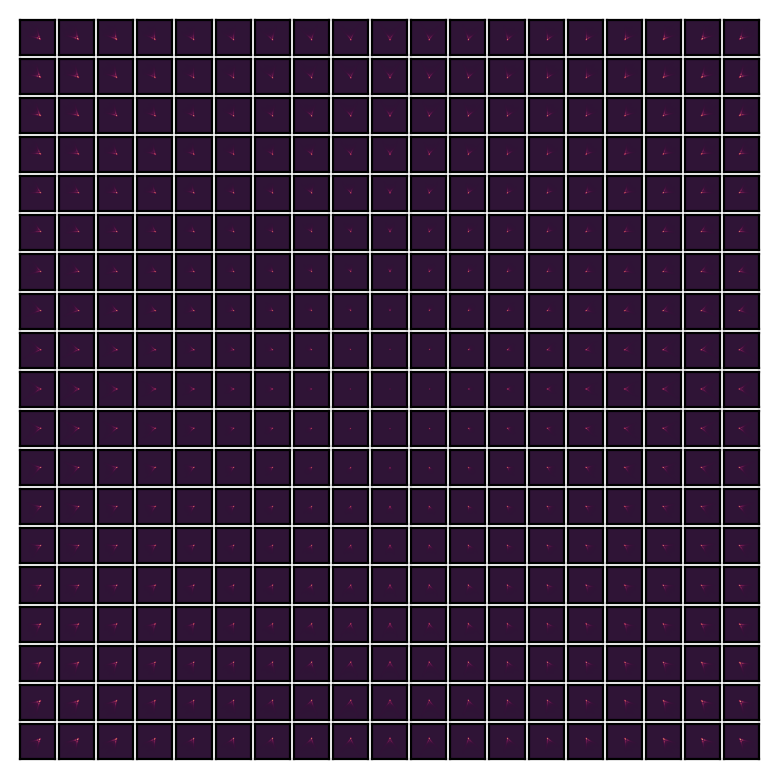

In [11]:
eigp.view_psfs()

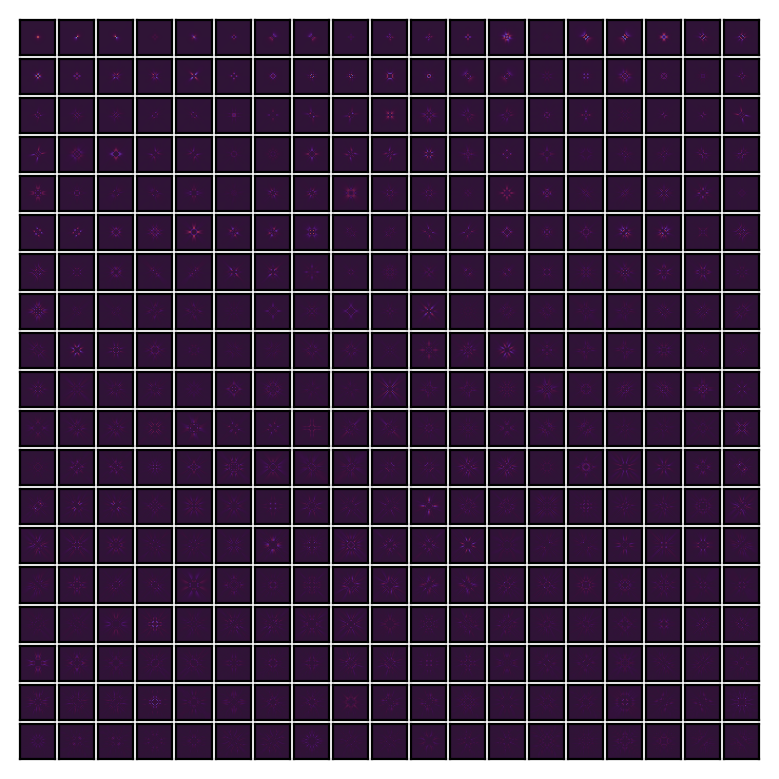

In [12]:
eigp.view_eigenpsfs()

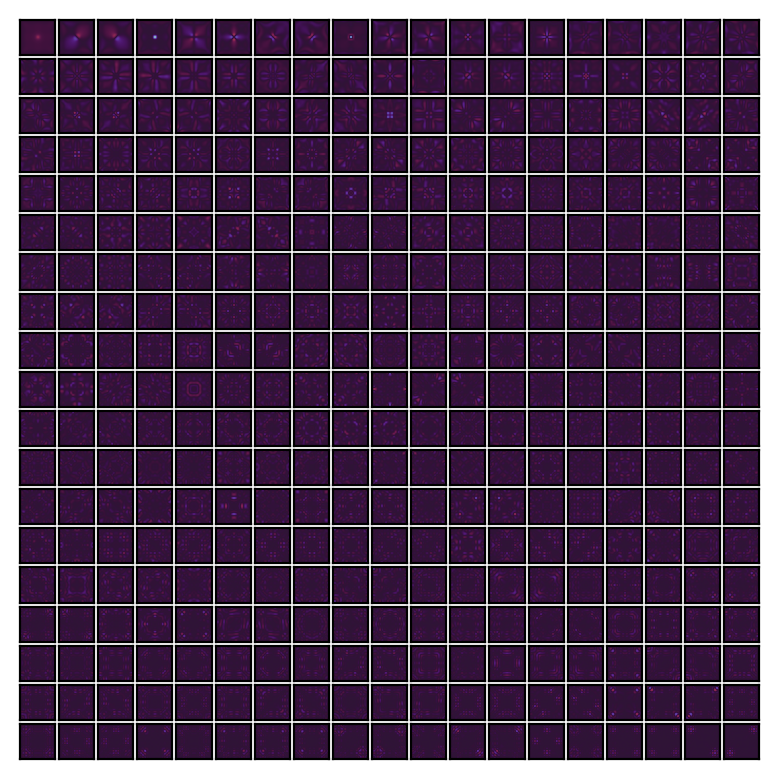

In [13]:
eigp.view_eigencoeffs()

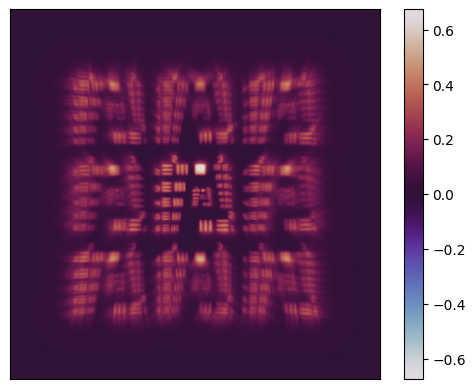

In [14]:
eigp.view_image()

## Explicit Full Integral Blurring
For 375 x 375 image, takes about 12.5min on cpu, 2.5min on gpu.

In [15]:
device = 'cuda'
fullintegral = lens.fullintegral(prop_dist=focus, psfmag=psfmag, device=device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [02:32<00:00,  1.23it/s]


In [16]:
cropped_fullintegral = utils.crop(fullintegral.cpu(), len(padded_usaf))

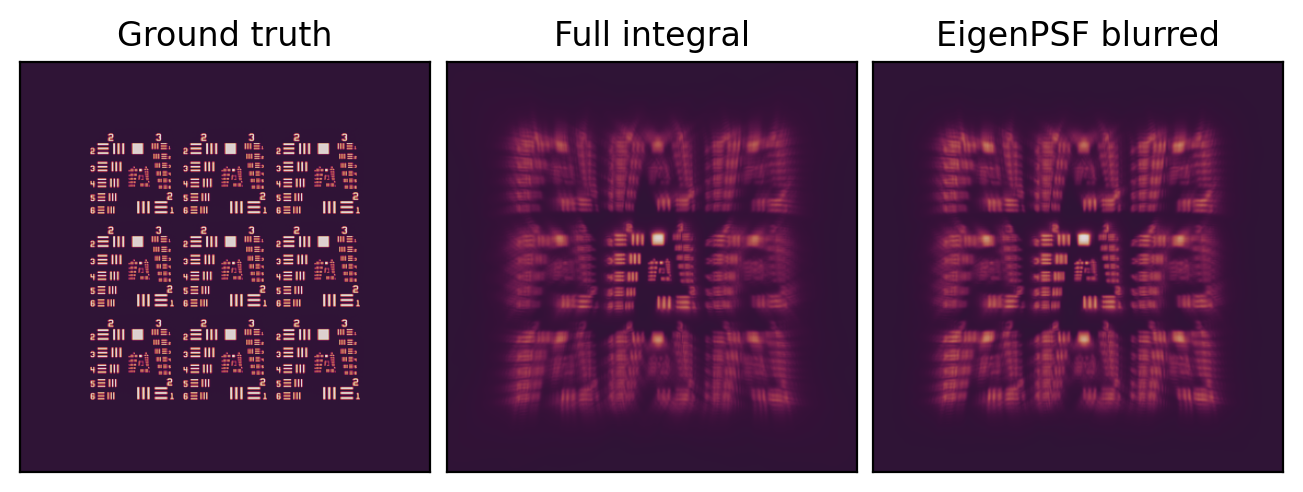

In [17]:
fig, axes = plt.subplots(1, 3, dpi=200, constrained_layout=True)
[ax.set(xticks=[], yticks=[]) for ax in axes.ravel()]
ax = axes[0]
ax.imshow(padded_usaf, cmap='twilight', vmin=-1, vmax=1)
ax.set_title('Ground truth')

ax = axes[1]
ax.imshow(cropped_fullintegral, cmap='twilight', vmin=-0.7, vmax=0.7)
ax.set_title('Full integral')

ax = axes[2]
ax.imshow(eigp.img, cmap='twilight', vmin=-0.7, vmax=0.7)
ax.set_title('EigenPSF blurred')
plt.show()

## EigenCWD Deblurring
For 4000 iterations on 375 x 375 image:
- 5 x 5 sampled PSFs takes 2min on cpu, 8 seconds on gpu.
- 19 x 19 sampled PSFs takes 1hr on cpu, 2min 40s on gpu.

In [18]:
img = cropped_fullintegral

eigc = EigenCWD(
    obj=torch.from_numpy(padded_usaf).type(torch.float32),
    img=cropped_fullintegral.type(torch.float32),
    device="cuda",
)
eigc.eigencwd(eigp.eigenpsfs.type(torch.float32),
              eigp.eigencoeffs.type(torch.float32),
              niter=4000,
              verbose=False,
              mu=1e5,
              )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [02:37<00:00, 25.32it/s]


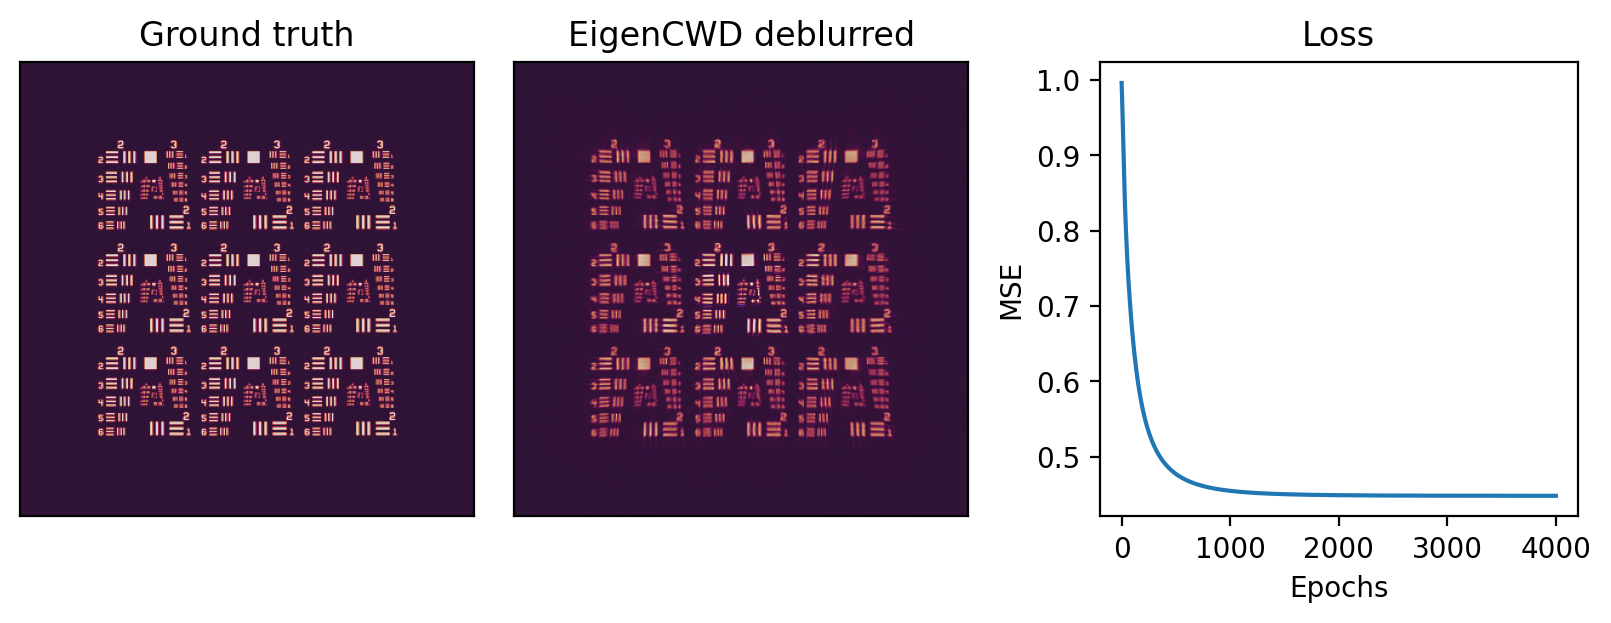

In [19]:
fig, axes = plt.subplots(1, 3, dpi=200, constrained_layout=True, figsize=(8,3))
ax = axes[0]
ax.imshow(padded_usaf, cmap='twilight', vmax=1, vmin=-1)
ax.set_title('Ground truth')
ax.set(xticks=[], yticks=[])

ax = axes[1]
ax.imshow(eigc.current_estimate.real.detach().cpu(), cmap='twilight', vmax=1, vmin=-1)
ax.set_title('EigenCWD deblurred')
ax.set(xticks=[], yticks=[])

ax = axes[2]
ax.plot(torch.stack(eigc.mse).detach().cpu())
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.set_title('Loss')

plt.show()